# Data Dictionary:
## **1. Download Data**
> train_dataset    |   torchvision.datasets.mnist.FashionMNIST<br>
eval_dataset       |   torchvision.datasets.mnist.FashionMNIST

## **2. Prepare Data**


> train_images     |   numpy array (60000, 784)
<br>train_labels   |   numpy array (60000, )
<br>eval_images    |   numpy array (10000, 784)
<br>eval_labels    |   numpy array (10000, )
<br> standardized_train_images | numpy array (60000, 784)
<br> standardized_eval_images |   numpy array (10000, 784)




# **To-Do**
1. Test PCA with sharpened data
2. Test Feature selection on PCs

Add in F1 Score & Confusion matrix

In [0]:
# a = []
# while(1):
#     a.append('1')

# Importing of Libraries

In [0]:
import torchvision
from PIL import Image

import pandas as pd
import numpy as np
import scipy as sp
from scipy import ndimage
from scipy.stats import norm
import scipy.signal as sig

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from skimage import io
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time, random, math


In [0]:
%matplotlib inline

# Functions

# Data Extraction

In [0]:
# download the Fashion MNIST training data
train_dataset = torchvision.datasets.FashionMNIST(root='./', train=True, download=True)

# download the Fashion MNIST evaluation data
eval_dataset = torchvision.datasets.FashionMNIST(root='./', train=False, download=True)

In [45]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FD380B4AC18>, 9)

In [0]:
labels_dict = {0: "T-shirt/top",
               1: "Trouser",
               2: "Pullover",
               3: "Dress",
               4: "Coat",
               5: "Sandal",
               6: "Shirt",
               7: "Sneaker",
               8: "Bag",
               9: "Ankle boot"}

# Data Preparation

**Reshape data from 28x28 into 784**

In [0]:
train_images = train_dataset.data.numpy().reshape(-1,28*28)
train_labels = train_dataset.targets.data.numpy()

In [0]:
train_images.shape

(60000, 784)

In [0]:
train_labels.shape

(60000,)

In [0]:
eval_images = eval_dataset.data.numpy().reshape(-1,28*28)
eval_labels = eval_dataset.targets.data.numpy()

In [0]:
eval_images.shape

(10000, 784)

In [0]:
eval_labels.shape

(10000,)

**Standardize data**

In [0]:
standardized_train_images = StandardScaler().fit_transform(train_images)
standardized_eval_images = StandardScaler().fit_transform(eval_images)

# Support Vector Machine W/ PCA

In [0]:
# optimal number for random_state
random_seed = 42

**Run SVM on Untreated Data**

In [0]:
svm = SVC(kernel='rbf', random_state=random_seed)

In [0]:
# cvs = cross_val_score(svm, train_images, train_labels,scoring='precision_macro')
# print np.mean(cvs)

In [0]:
%%time

svm.fit(train_images,train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
y_pred_1 = svm.predict(eval_images)

print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(eval_labels, y_pred_1) * 100)))
f1 = f1_score(eval_labels, y_pred_1,average='macro')
print('F1 score: %f' % f1)

Model classification accuracy: 88.28%
F1 score: 0.882265


**Run SVM on Standardized Data**

In [0]:
svm = SVC(kernel='rbf', random_state=random_seed)

In [0]:
cvs = cross_val_score(svm, train_images, train_labels,scoring='precision_macro')
print(np.mean(cvs))

0.8890649801213758


In [0]:
%%time

svm.fit(standardized_train_images,train_labels)

CPU times: user 14min 35s, sys: 163 ms, total: 14min 35s
Wall time: 14min 35s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
y_pred_2 = svm.predict(standardized_eval_images)

print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(eval_labels, y_pred_2) * 100)))
f1 = f1_score(eval_labels, y_pred_2,average='macro')
print('F1 score: %f' % f1)

Model classification accuracy: 88.36%
F1 score: 0.882864


**Run SVM with PCA**

In [0]:
pca = PCA()

pca.n_components = 11

pca_train_images = pca.fit_transform(standardized_train_images)
pca_eval_images = pca.fit_transform(standardized_eval_images)

In [0]:
svm = SVC(kernel='rbf', gamma="scale", C=100, random_state=random_seed)

In [0]:
%%time

svm.fit(pca_train_images,train_labels)

CPU times: user 1min 1s, sys: 153 ms, total: 1min 1s
Wall time: 1min 2s


SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
y_pred_3 = svm.predict(pca_eval_images)

print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(eval_labels, y_pred_3) * 100)))
f1 = f1_score(eval_labels, y_pred_3,average='macro')
print('F1 score: %f' % f1)

Model classification accuracy: 81.15%
F1 score: 0.809186


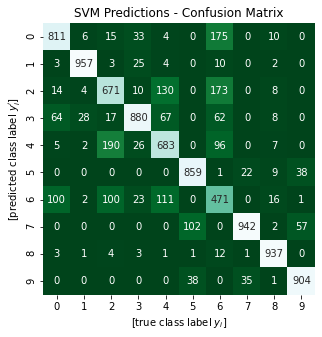

In [0]:
mat = confusion_matrix(eval_labels, y_pred_3)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r', xticklabels=labels_dict, yticklabels=labels_dict)

# add plot axis labels
plt.xlabel('[true class label $y_{i}$]')
plt.ylabel('[predicted class label $y_{i}\'$]')

# add plot title
plt.title('SVM Predictions - Confusion Matrix');

**SVM GridSearchCV**

Tuning RBF C Values

In [0]:
c_values = [0.000001, 0.0001, 0.1, 1, 100, 10000]
gamma_values = ['auto','scale']
degree_values = np.arange(1, 6, 1)
# kernel_types = ['linear','rbf','poly','sigmoid']
# param_grid = dict(kernel=kernel_types, gamma=gamma_range, C=c_range,degree=degree_values)
# tuning_param_grid = [{'kernel':['linear'], 'C':c_values}]
tuning_param_grid = [{'kernel':['rbf'], 'C':c_values, 'gamma':gamma_values}]
                    #  {'kernel':['poly'],'degree':degree_values, 'C':c_values, 'gamma':gamma_values}]
                    #  {'kernel':['sigmoid'], 'C':c_values, 'gamma':gamma_values}]
svm = SVC()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_seed)

In [0]:
%%time

grid = GridSearchCV(svm, param_grid=tuning_param_grid, cv=cv, verbose=10, n_jobs=-1)
grid.fit(pca_train_images,train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 42.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 69.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 102.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 102.7min finished


CPU times: user 1min 3s, sys: 421 ms, total: 1min 4s
Wall time: 1h 43min 42s


In [0]:
print ("The best classifier is: " , grid.best_estimator_)
print ('Score of best classifier :', grid.score(pca_eval_images,eval_labels))

The best classifier is:  SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Score of best classifier : 0.8112


In [0]:
# grid.best_param.get("kernel")
# grid.best_param.get("gamma")
# grid.best_param.get("C")
# grid.best_param.get("degree")
# grid.best_param

In [0]:
for param, score in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score']):
    print(param, score)

{'C': 1e-06, 'gamma': 'auto', 'kernel': 'rbf'} 0.32330000000000003
{'C': 1e-06, 'gamma': 'scale', 'kernel': 'rbf'} 0.6828666666666667
{'C': 0.0001, 'gamma': 'auto', 'kernel': 'rbf'} 0.32330000000000003
{'C': 0.0001, 'gamma': 'scale', 'kernel': 'rbf'} 0.6828666666666667
{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'} 0.6247166666666666
{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} 0.7956166666666667
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} 0.7856500000000001
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} 0.82825
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'} 0.7752666666666667
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'} 0.8544333333333334
{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf'} 0.7752333333333334
{'C': 10000, 'gamma': 'scale', 'kernel': 'rbf'} 0.8441000000000001


Increase C tuning of RBF C parameter

In [0]:
c_values = [150,175,200,225,250]
gamma_values = ['scale']
degree_values = np.arange(1, 6, 1)
# kernel_types = ['linear','rbf','poly','sigmoid']
# param_grid = dict(kernel=kernel_types, gamma=gamma_range, C=c_range,degree=degree_values)
# tuning_param_grid = [{'kernel':['linear'], 'C':c_values}]
tuning_param_grid = [{'kernel':['rbf'], 'C':c_values, 'gamma':gamma_values}]

In [0]:
%%time

grid = GridSearchCV(svm, param_grid=tuning_param_grid, cv=cv, verbose=10, n_jobs=-1)
grid.fit(pca_train_images,train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  9.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 10.6min finished


CPU times: user 1min 14s, sys: 310 ms, total: 1min 14s
Wall time: 11min 48s


In [0]:
print ("The best classifier is: " , grid.best_estimator_)
print ('Score of best classifier :', grid.score(pca_eval_images,eval_labels))

The best classifier is:  SVC(C=150, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Score of best classifier : 0.81


In [0]:
for param, score in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score']):
    print(param, score)

{'C': 150, 'gamma': 'scale', 'kernel': 'rbf'} 0.8548333333333333
{'C': 175, 'gamma': 'scale', 'kernel': 'rbf'} 0.8547
{'C': 200, 'gamma': 'scale', 'kernel': 'rbf'} 0.8546166666666666
{'C': 225, 'gamma': 'scale', 'kernel': 'rbf'} 0.8543666666666667
{'C': 250, 'gamma': 'scale', 'kernel': 'rbf'} 0.8543833333333334


Tuning Poly Parameters

In [0]:
c_values = [0.00001, 0.1, 1, 150, 1000]
gamma_values = ['scale']
degree_values = np.arange(1, 6, 1)
# kernel_types = ['linear','rbf','poly','sigmoid']
# param_grid = dict(kernel=kernel_types, gamma=gamma_range, C=c_range,degree=degree_values)
# tuning_param_grid = [{'kernel':['linear'], 'C':c_values}]
tuning_param_grid = [{'kernel':['poly'], 'C':c_values, 'gamma':gamma_values, 'degree':degree_values}]

In [0]:
%%time

poly_grid = GridSearchCV(svm, param_grid=tuning_param_grid, cv=cv, verbose=10, n_jobs=-1)
poly_grid.fit(pca_train_images,train_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 35.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 39.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 48.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 73.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 132.1min finished


CPU times: user 9min 23s, sys: 488 ms, total: 9min 24s
Wall time: 2h 21min 31s


In [0]:
print ("The best classifier is: " , poly_grid.best_estimator_)
print ('Score of best classifier :', poly_grid.score(pca_eval_images,eval_labels))

The best classifier is:  SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Score of best classifier : 0.7994


In [0]:
for param, score in zip(poly_grid.cv_results_['params'], poly_grid.cv_results_['mean_test_score']):
    print(param, score)

{'C': 1e-05, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'} 0.5223000000000001
{'C': 1e-05, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'} 0.4073666666666667
{'C': 1e-05, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.3287833333333333
{'C': 1e-05, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'} 0.21523333333333333
{'C': 1e-05, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'} 0.17116666666666663
{'C': 0.1, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'} 0.7710166666666668
{'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'} 0.7806833333333334
{'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.7810666666666667
{'C': 0.1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'} 0.7496166666666666
{'C': 0.1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'} 0.7256333333333334
{'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'} 0.7885333333333333
{'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'} 0.8109
{'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'

In [0]:
c_values = [750, 1000, 2000]
gamma_values = ['scale']
# degree_values = np.arange(1, 6, 1)
degree_values = [3]
# kernel_types = ['linear','rbf','poly','sigmoid']
# param_grid = dict(kernel=kernel_types, gamma=gamma_range, C=c_range,degree=degree_values)
# tuning_param_grid = [{'kernel':['linear'], 'C':c_values}]
tuning_param_grid = [{'kernel':['poly'], 'C':c_values, 'gamma':gamma_values, 'degree':degree_values}]

In [0]:
%%time

poly_grid_2 = GridSearchCV(svm, param_grid=tuning_param_grid, cv=cv, verbose=10, n_jobs=-1)
poly_grid_2.fit(pca_train_images,train_labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 30.9min remaining: 15.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 41.9min remaining: 10.5min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 54.7min finished


CPU times: user 18min 33s, sys: 329 ms, total: 18min 33s
Wall time: 1h 13min 13s


In [0]:
print ("The best classifier is: " , poly_grid_2.best_estimator_)
print ('Score of best classifier :', poly_grid_2.score(pca_eval_images,eval_labels))

The best classifier is:  SVC(C=2000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Score of best classifier : 0.7979


In [0]:
for param, score in zip(poly_grid_2.cv_results_['params'], poly_grid_2.cv_results_['mean_test_score']):
    print(param, score)

{'C': 750, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.84555
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.8456833333333333
{'C': 2000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.8459


In [0]:
c_values = [3000,4000]
gamma_values = ['scale']
# degree_values = np.arange(1, 6, 1)
degree_values = [3]
# kernel_types = ['linear','rbf','poly','sigmoid']
# param_grid = dict(kernel=kernel_types, gamma=gamma_range, C=c_range,degree=degree_values)
# tuning_param_grid = [{'kernel':['linear'], 'C':c_values}]
tuning_param_grid = [{'kernel':['poly'], 'C':c_values, 'gamma':gamma_values, 'degree':degree_values}]

In [0]:
%%time

poly_grid_3 = GridSearchCV(svm, param_grid=tuning_param_grid, cv=cv, verbose=10, n_jobs=-1)
poly_grid_3.fit(pca_train_images,train_labels)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 64.6min remaining: 64.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 79.4min remaining: 34.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 104.3min finished


CPU times: user 27min 53s, sys: 312 ms, total: 27min 54s
Wall time: 2h 12min 12s


In [0]:
print ("The best classifier is: " , poly_grid_3.best_estimator_)
print ('Score of best classifier :', poly_grid_3.score(pca_eval_images,eval_labels))

The best classifier is:  SVC(C=3000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Score of best classifier : 0.796


In [0]:
for param, score in zip(poly_grid_3.cv_results_['params'], poly_grid_3.cv_results_['mean_test_score']):
    print(param, score)

{'C': 3000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.8455666666666666
{'C': 4000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.8452166666666667


In [0]:
svm = SVC(C=150,kernel="rbf",gamma="scale")

In [0]:
%%time

svm.fit(pca_train_images,train_labels)

CPU times: user 1min 14s, sys: 123 ms, total: 1min 14s
Wall time: 1min 14s


SVC(C=150, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred_test = svm.predict(pca_eval_images)


In [0]:
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(eval_labels, y_pred_test) * 100)))
f1 = f1_score(eval_labels, y_pred_test,average='macro')
print('F1 score: %f' % f1)

Model classification accuracy: 81.03%
F1 score: 0.808100


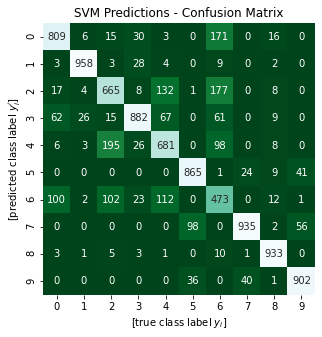

In [0]:
mat = confusion_matrix(eval_labels, y_pred_test)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r', xticklabels=labels_dict, yticklabels=labels_dict)

# add plot axis labels
plt.xlabel('[true class label $y_{i}$]')
plt.ylabel('[predicted class label $y_{i}\'$]')

# add plot title
plt.title('SVM Predictions - Confusion Matrix');

**Recursive feature elimination**


m = RFECV(RandomForestClassifier(), scoring='accuracy')
m.fit(X, y)

# SVM with HOG Features

## Apply HOG on train Images

In [0]:
#Testing the hog Feature with 10k data
sampled_train_images = pd.DataFrame(train_images).sample(10000, axis=0, random_state=random_seed)
sampled_train_labels = train_labels[sampled_train_images.index.tolist()]

In [0]:
hog_sampled_train_images = sampled_train_images.apply(lambda x : x.values.reshape(28,28,1),axis=1)

In [0]:
#Testing hog feature with all data
hog_train_images = pd.DataFrame(train_images).apply(lambda x : x.values.reshape(28,28,1),axis=1)

In [0]:
orientation = 12
pixel_cell = (7,2)

### Sampled Data Test
# Orientation 4 with (14 x 14) cells = 62.8% accuracy
# Orientation 4 with (7 x 7) cells = 79.12% accuracy
# Orientation 8 with (7 x 7) cells = 83.52% accuracy
# Orientation 6 with (7 x 7) cells = 81.89% accuracy
# Orientation 16 with (7 x 7) cells = 85.45% accuracy
# Orientation 32 with (7 x 7) cells = 85.54% accuracy
# Orientation 32 with (14 x 14) cells = 78.46% accuracy
# Orientation 4 with (2,7) cells = 84.65% accuracy
# Orientation 2 with (2,7) cells = 74.6% accuracy
# Orientation 4 with (7,2) cells = 86.76% accuracy
# Orientation 6 with (7,2) cells = 87.82% accuracy
# Orientation 8 with (7,2) cells = 87.76% accuracy
# Orientation 12 with (7,2) cells = 88.19% accuracy
# Orientation 16 with (7,2) cells = 87.97% accuracy

In [56]:
# extract the hog features of all training images

# init list of hog features
train_images_hog_features = []
train_images_hog_images = []

# iterate over all training images
for i, train_image in enumerate(hog_sampled_train_images):
    
    # extract hog features of current training image
    train_features, train_image = hog(train_image, orientations=orientation, pixels_per_cell=pixel_cell, cells_per_block=(1, 1), visualize=True, transform_sqrt=True)
    # print(hog(sampled_train_image, orientations=2, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=True))
    # collect extracted hog features
    train_images_hog_features.append(train_features)
    train_images_hog_images.append(train_image)
    
    # case: print image processing status
    if i % 10000 == 0:
        
        # print log message
        print('[LOG] {} features of training image {} succesfully extracted.'.format(str(len(train_features)), str(i).zfill(5)))

[LOG] 672 features of training image 00000 succesfully extracted.


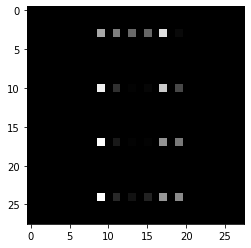

In [59]:
plt.imshow(train_images_hog_images[77], cmap='gray')

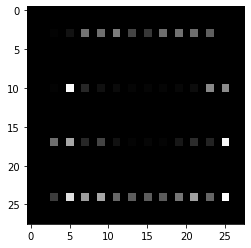

In [0]:
plt.imshow(train_images_hog_images[3100], cmap='gray')

##Apply HOG on Eval images too

In [0]:
hog_eval_images = pd.DataFrame(eval_images).apply(lambda x : x.values.reshape(28,28,1),axis=1)

In [0]:
# extract the hog features of all training images

# init list of hog features
eval_images_hog_features = []
eval_images_hog_images = []

# iterate over all training images
for i, eval_image in enumerate(hog_eval_images):
    
    # extract hog features of current training image
    train_features, train_image = hog(eval_image, orientations=orientation, pixels_per_cell=pixel_cell, cells_per_block=(1, 1), visualize=True, transform_sqrt=True)
    # print(hog(sampled_train_image, orientations=4, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=True))
    # collect extracted hog features
    eval_images_hog_features.append(train_features)
    eval_images_hog_images.append(train_image)
    
    # case: print image processing status
    if i % 10000 == 0:
        
        # print log message
        print('[LOG] {} features of training image {} succesfully extracted.'.format(str(len(train_features)), str(i).zfill(5)))

[LOG] 162 features of training image 00000 succesfully extracted.


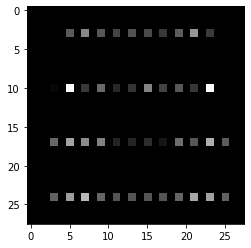

In [0]:
plt.imshow(eval_images_hog_images[5000], cmap='gray')

## Training SVM with HOG

In [0]:
svm = SVC(kernel='rbf', gamma="scale", C=0.1, random_state=random_seed)

In [0]:
# Training it with only one class
%%time

svm.fit(train_images_hog_features,train_labels == 6)

CPU times: user 5min 47s, sys: 101 ms, total: 5min 47s
Wall time: 5min 48s


SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
%%time
#Dont DC PLEASE
#hahaha
svm.fit(train_images_hog_features,train_labels)

CPU times: user 21min 45s, sys: 313 ms, total: 21min 45s
Wall time: 21min 46s


SVC(C=150, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
y_pred_sampled_hog = svm.predict(eval_images_hog_features)

print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(eval_labels==6, y_pred_sampled_hog) * 100)))
f1 = f1_score(eval_labels, y_pred_sampled_hog,average='macro')
print('F1 score: %f' % f1)

Model classification accuracy: 90.14999999999999%
F1 score: 0.018207


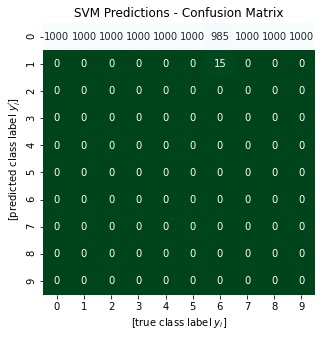

In [0]:
mat = confusion_matrix(eval_labels, y_pred_sampled_hog)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r', xticklabels=labels_dict, yticklabels=labels_dict)

# add plot axis labels
plt.xlabel('[true class label $y_{i}$]')
plt.ylabel('[predicted class label $y_{i}\'$]')

# add plot title
plt.title('SVM Predictions - Confusion Matrix');

## Training HOG + PCA

In [0]:
train_images_hog_features_df = pd.DataFrame(train_images_hog_features)
eval_images_hog_features_df = pd.DataFrame(eval_images_hog_features)

NameError: ignored

In [0]:
train_images_hog_features_df.shape

(60000, 672)

In [0]:
eval_images_hog_features_df.shape

(10000, 672)

In [0]:
pca_train_images_df = pd.DataFrame(pca_train_images)
pca_eval_images_df = pd.DataFrame(pca_eval_images)

In [0]:
pca_train_images_df.shape

(60000, 11)

In [0]:
pca_eval_images_df.shape

(10000, 11)

In [0]:
pca_hog_train_images = train_images_hog_features_df.merge(pca_train_images_df, left_index=True, right_index=True)

In [0]:
pca_hog_eval_images = eval_images_hog_features_df.merge(pca_eval_images_df, left_index=True, right_index=True)

In [0]:
svm = SVC(kernel='rbf', gamma="scale", C=150, random_state=random_seed)

In [0]:
%%time

svm.fit(pca_hog_train_images,train_labels)

CPU times: user 9min 53s, sys: 619 ms, total: 9min 53s
Wall time: 9min 53s


SVC(C=150, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
y_pred_hog_pca = svm.predict(pca_hog_eval_images)

print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(eval_labels, y_pred_hog_pca) * 100)))
f1 = f1_score(eval_labels, y_pred_hog_pca,average='macro')
print('F1 score: %f' % f1)

Model classification accuracy: 88.71%
F1 score: 0.886761


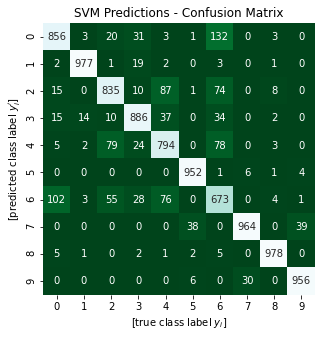

In [0]:
mat = confusion_matrix(eval_labels, y_pred_hog_pca)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r', xticklabels=labels_dict, yticklabels=labels_dict)

# add plot axis labels
plt.xlabel('[true class label $y_{i}$]')
plt.ylabel('[predicted class label $y_{i}\'$]')

# add plot title
plt.title('SVM Predictions - Confusion Matrix');

## Classifying Class 1 and 6 individually

In [0]:
class_6_train_labels = (sampled_train_labels == 6)

In [0]:
class_6_train_labels.shape

(60000,)

In [0]:
np.count_nonzero(class_6_train_labels)

2014

In [0]:
svm = SVC(kernel='rbf', gamma="scale", random_state=42, verbose=50)    
# pca_accuracies[pca_component] = np.array(list_y_preds).argmax(axis=0)

In [0]:
%%time

svm.fit(train_images_hog_features,class_6_train_labels)

[LibSVM]CPU times: user 1min 50s, sys: 428 ms, total: 1min 50s
Wall time: 1min 50s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=50)

In [0]:
class_6_eval_labels = (eval_labels == 6)

In [0]:
y_pred_hog_pca = svm.predict(eval_images_hog_features)

print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(class_6_eval_labels, y_pred_hog_pca) * 100)))
f1 = f1_score(class_6_eval_labels, y_pred_hog_pca,average='macro')
print('F1 score: %f' % f1)

Model classification accuracy: 93.65%
F1 score: 0.778867


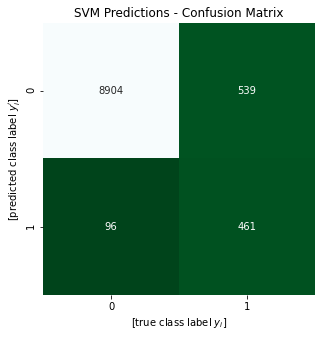

In [0]:
mat = confusion_matrix(class_6_eval_labels, y_pred_hog_pca)

# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r', xticklabels=[0,1], yticklabels=[0,1])

# add plot axis labels
plt.xlabel('[true class label $y_{i}$]')
plt.ylabel('[predicted class label $y_{i}\'$]')

# add plot title
plt.title('SVM Predictions - Confusion Matrix');